****Initial EDA****

***Notes***
* Hass Avocado Board Data
    * 2017 - 2020 CSVs:
        * YYYY-market-region-hab-data.csv ("4-week Period Reports")
            * ['Geography', 'Segment', 'Variety', 'Timeframe', 'Period',
       'Current Year Week Ending', 'Units Prior Year', 'Units Current Year',
       'Unit Variance', 'Dollars Prior Year', 'Dollars Current Year',
       'Dollar Variance', 'ASP Prior Year', 'ASP Current Year',
       'ASP Variance']
        * YYYY-plu-total-hab-data.csv ("Weekly Retail Volume & Price Reports")
            * ['Geography', 'Timeframe', 'Current Year Week Ending', 'Type',
       'ASP Current Year', 'Total Bulk and Bags Units', '4046 Units',
       '4225 Units', '4770 Units', 'TotalBagged Units', 'SmlBagged Units',
       'LrgBagged Units', 'X-LrgBagged Units']
        * YYYY-volume.csv ("Volume Data 7 Projections, kg")
            * ['Week', 'Status', 'Total Volume', 'California', 'Chile', 'Mexico',
       'Peru', 'Colombia']
    * PDF Country Profiles and Market Reviews:
        * California 2020, 2017
        * Mexico 2019, 2014
        * Peru 2019, 2018
        * Chile 2018, 2014
        * Spain 2018, 2014
        * Europe 2018 Market Review
        * World 2018 Market Review
        * 2017: Australia, New Zealand
        * 2016: Tanzania, South Africa, Morocco, Mexico Jalisco, Kenya, Brazil, Colombia
    * Missing:
        * Global Trade Report CSVs
            * imports/exports by weight (kg) and quarter
            * shows which countries exported to which
        * Data for Regional Composite Reports
            * retail dollar growth trends, hass vs total produce
            * Sales by dollar and unit, average selling price
* Kaggle HAB data (avo-volume-and-price-data.csv)
    * ['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region']
* Google Trends
* Mexico Tariffs

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [3]:
#import Hass Avocado Board data

kag_df = pd.read_csv("data/avo-volume-and-price-data.csv")

def create_df(fname, year_start, year_end):
    dfs = []
    for y in range(year_start, year_end+1):
        dfs.append(pd.read_csv(f"data/{y}-{fname}.csv"))
    return pd.concat(dfs)

per_df = create_df('market-region-hab-data',2017,2020)
wkly_rtl_df = create_df('plu-total-hab-data',2017,2020)
vol_df = create_df('volume',2017,2020)

In [5]:
per_df['Date']

KeyError: 'Date'

In [116]:
kag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [114]:
wkly_rtl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17388 entries, 0 to 863
Data columns (total 13 columns):
Geography                    17388 non-null object
Timeframe                    17388 non-null object
Current Year Week Ending     17388 non-null datetime64[ns]
Type                         17388 non-null object
ASP Current Year             17388 non-null float64
Total Bulk and Bags Units    17388 non-null float64
4046 Units                   17388 non-null float64
4225 Units                   17388 non-null float64
4770 Units                   17388 non-null float64
TotalBagged Units            17388 non-null float64
SmlBagged Units              17388 non-null float64
LrgBagged Units              17388 non-null float64
X-LrgBagged Units            17388 non-null float64
dtypes: datetime64[ns](1), float64(9), object(3)
memory usage: 2.5+ MB


In [113]:
wkly_rtl_df['Current Year Week Ending'] = pd.to_datetime(wkly_rtl_df['Current Year Week Ending'])

In [100]:
print(vol_df.columns)

Index(['Week', 'Status', 'Total Volume', 'California', 'Chile', 'Mexico',
       'Peru', 'Colombia'],
      dtype='object')


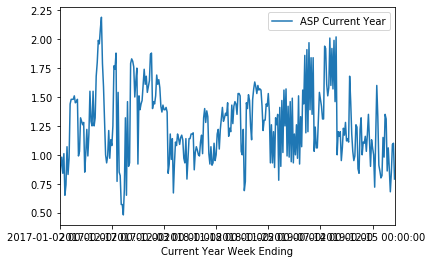

In [87]:
#Check if ambiguously named 'ASP Current Year' column looks like a YTD average. The value does not converge over the course of each year, so the answer is no.

wkly_rtl_df.loc[wkly_rtl_df['Geography']=='Detroit',['Current Year Week Ending', 'ASP Current Year']].plot('Current Year Week Ending')

In [20]:
per_df

,Geography,Segment,Variety,Timeframe,Period,Current Year Week Ending,Units Prior Year,Units Current Year,Unit Variance,Dollars Prior Year,Dollars Current Year,Dollar Variance,ASP Prior Year,ASP Current Year,ASP Variance
0,Albany,Avocados,Hass,Last 04 Wks,1,2017-01-29 00:00:00,407688.25,414997.59,0.017929,474096.20,526144.34,0.109784,1.162889,1.267825,0.090237
1,Albany,Avocados,Hass,Last 04 Wks,2,2017-02-26 00:00:00,464174.45,474327.41,0.021873,484448.36,643283.21,0.327867,1.043677,1.356201,0.299445
2,Albany,Avocados,Hass,Last 04 Wks,3,2017-03-26 00:00:00,412013.41,428197.68,0.039281,492765.05,536982.97,0.089734,1.195993,1.254054,0.048546
3,Albany,Avocados,Hass,Last 04 Wks,4,2017-04-23 00:00:00,427319.20,388241.62,-0.091448,496838.57,557034.31,0.121158,1.162687,1.434762,0.234005
4,Albany,Avocados,Hass,Last 04 Wks,5,2017-05-21 00:00:00,502563.73,473973.05,-0.056890,527758.58,587504.68,0.113207,1.050133,1.239532,0.180357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Spokane,Avocados,Hass,Last 04 Wks,2,2020-02-23 00:00:00,480182.53,503555.11,0.048674,542228.29,571008.47,0.053078,1.129213,1.133954,0.004199
104,St. Louis,Avocados,Hass,Last 04 Wks,2,2020-02-23 00:00:00,930887.41,916271.91,-0.015701,972327.90,989709.00,0.017876,1.044517,1.080148,0.034112
105,Syracuse,Avocados,Hass,Last 04 Wks,2,2020-02-23 00:00:00,412062.30,422557.18,0.025469,455166.40,460464.52,0.011640,1.104606,1.089709,-0.013486
106,Tampa,Avocados,Hass,Last 04 Wks,2,2020-02-23 00:00:00,2943022.21,2878899.18,-0.021788,2749727.35,2678733.13,-0.025819,0.934321,0.930471,-0.004120


In [49]:
vol_df.describe(percentiles = [.25])

,Week,Status,Total Volume,California,Chile,Mexico,Peru,Colombia
count,195,195,195,195,195,195,195,195
unique,195,2,195,143,99,187,92,3
top,"May 28, 2017",Actual,"40,739,925",0,0,0,0,0
freq,1,170,1,53,94,9,100,105


In [6]:
vol_df.sample

<bound method NDFrame.sample of             Week      Status Total Volume California      Chile      Mexico  \
0    Jan 1, 2017      Actual   35,100,521     49,737  1,023,459  34,027,325   
1    Jan 8, 2017      Actual   40,920,289    157,060  1,526,467  39,236,762   
2   Jan 15, 2017      Actual   53,723,606    215,612  1,468,592  52,039,402   
3   Jan 22, 2017      Actual   55,606,793    827,113  1,445,898  53,333,782   
4   Jan 29, 2017      Actual   44,287,021  1,027,998  1,111,063  42,147,960   
..           ...         ...          ...        ...        ...         ...   
33  Aug 23, 2020  Projection    3,229,005          0          0           0   
34  Aug 30, 2020  Projection    2,779,146          0          0           0   
35   Sep 6, 2020  Projection    1,440,752          0          0           0   
36  Sep 13, 2020  Projection      774,135          0          0           0   
37  Sep 20, 2020  Projection      279,549          0          0           0   

         Peru Colom

In [17]:
kag_df['Date'] = pd.to_datetime(kag_df['Date'])
kag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null datetime64[ns]
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.9+ MB


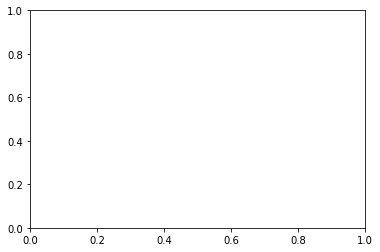

In [29]:
fig, ax = plt.subplots()